<a href="https://colab.research.google.com/github/Ishita-Si/BlazeTrack/blob/main/Models/transfer_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d phylake1337/fire-dataset
!unzip -q fire-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/phylake1337/fire-dataset
License(s): CC0-1.0
 88% 340M/387M [00:00<00:00, 456MB/s]
100% 387M/387M [00:00<00:00, 412MB/s]


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=40,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    brightness_range=(0.6, 1.4),
    fill_mode='nearest'
)

In [ ]:
train_gen = train_datagen.flow_from_directory(
    "fire_dataset/",
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_gen = train_datagen.flow_from_directory(
    "fire_dataset/",
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=True
)

Found 800 images belonging to 2 classes.
Found 199 images belonging to 2 classes.


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=train_gen.classes
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: np.float64(0.6622516556291391), 1: np.float64(2.0408163265306123)}


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = True

for layer in base_model.layers[:100]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
model.compile(optimizer=Adam(1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,862,721 (7.11 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2),
    ModelCheckpoint("best_fire_model.keras", save_best_only=True)
]

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 930ms/step - accuracy: 0.9008 - loss: 0.2024 - val_accuracy: 0.8995 - val_loss: 0.2554 - learning_rate: 1.0000e-06
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 878ms/step - accuracy: 0.9214 - loss: 0.1963 - val_accuracy: 0.8945 - val_loss: 0.2854 - learning_rate: 1.0000e-06
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 898ms/step - accuracy: 0.8797 - loss: 0.1997 - val_accuracy: 0.8995 - val_loss: 0.2316 - learning_rate: 1.0000e-06
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 967ms/step - accuracy: 0.9191 - loss: 0.1812 - val_accuracy: 0.9045 - val_loss: 0.2502 - learning_rate: 1.0000e-06
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 834ms/step - accuracy: 0.9004 - loss: 0.2006 - val_accuracy: 0.9246 - val_loss: 0.2546 - learning_rate: 1.0000e-06
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 879ms/step - accuracy: 0.9087 - loss: 0.2136 - val_accuracy: 0.9095 - val_loss: 0.2475 - learning_rate: 1.0000e-07
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 838ms/step - acc

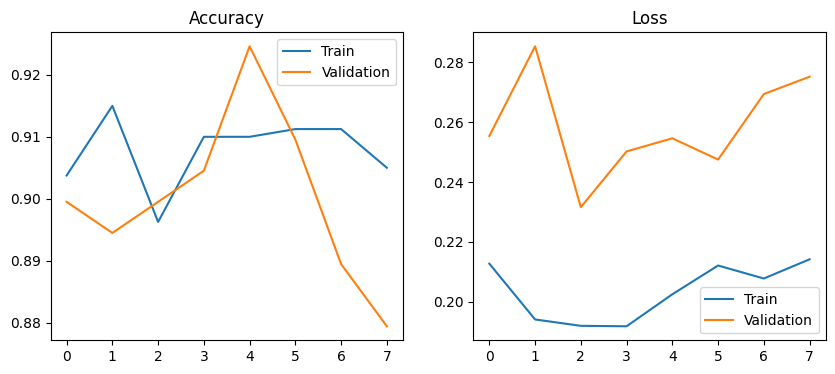

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

val_gen.reset()
preds = model.predict(val_gen, verbose=1)
y_pred = (preds > 0.5).astype(int)
y_true = val_gen.classes

print(classification_report(y_true, y_pred))

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 323ms/step
              precision    recall  f1-score   support

           0       0.77      0.72      0.75       151
           1       0.28      0.33      0.30        48

    accuracy                           0.63       199
   macro avg       0.52      0.53      0.52       199
weighted avg       0.65      0.63      0.64       199



In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Screenshot 2025-06-21 001926.png to Screenshot 2025-06-21 001926.png


In [ ]:
train_gen.class_indices

{'fire_images': 0, 'non_fire_images': 1}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
 Non Fire Images (Confidence: 94.12%)


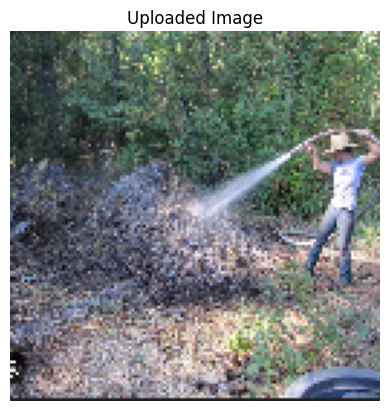

In [ ]:
from tensorflow.keras.preprocessing import image

for fn in uploaded.keys():
    img_path = fn
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)[0][0]

    class_map = train_gen.class_indices
    fire_label = min(class_map, key=class_map.get)
    non_fire_label = max(class_map, key=class_map.get)

    if prediction < 0.4:
        print(f" {fire_label.replace('_', ' ').title()} Detected (Confidence: {(1 - prediction) * 100:.2f}%)")
    else:
        print(f" {non_fire_label.replace('_', ' ').title()} (Confidence: {prediction * 100:.2f}%)")

    plt.imshow(img)
    plt.axis('off')
    plt.title("Uploaded Image")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Prediction: NO FIRE (Confidence: 0.9412)


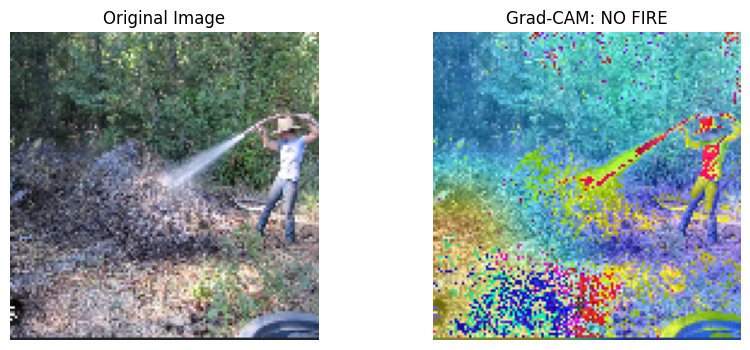

In [ ]:
for fn in uploaded.keys():
    img_path = fn
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
prediction = model.predict(img_array)[0][0]
label = 'FIRE' if prediction < 0.5 else 'NO FIRE'
print(f"Prediction: {label} (Confidence: {prediction:.4f})")

last_conv_layer_name = "Conv_1"
try:
    last_conv_layer = model.get_layer(last_conv_layer_name)
except:
    print("Conv_1 not found. Available layers:")
    for layer in model.layers[::-1]:
        if 'conv' in layer.name:
            print(layer.name)
    raise

grad_model = Model([model.inputs], [last_conv_layer.output, model.output])

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img_array)
    loss = predictions[:, 0]

grads = tape.gradient(loss, conv_outputs)[0]
pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

conv_outputs = conv_outputs[0]
heatmap = np.dot(conv_outputs, pooled_grads.numpy())

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

heatmap_resized = cv2.resize(heatmap, (128, 128))
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

superimposed_img = heatmap_colored * 0.4 + img_array * 255
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(np.uint8(superimposed_img[0]))

plt.title("Grad-CAM: " + label)
plt.axis('off')
plt.show()